In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

cwd = os.getcwd()
print(cwd)

\\ad\ap\homes$\kmp57\My Documents\GitHub\grid-uk-ml\notebooks


###  Load Data

In [2]:
path = r"..\data"
filename = "\df_clean.csv"
df = pd.read_csv(path + filename)
#df.reset_index()

df['Datetime'] = pd.to_datetime(df['Datetime'], format="%Y/%m/%d %H:%M:%S")
df = df.set_index("Datetime")


other_cols = ["hydro_perc",
    "other_perc",
    "storage_perc"]

df['other_perc'] = df[other_cols].sum(axis=1)
df.head()

,national_demand,pump_demand,demand_forecast,demand_outturn,demand_forecast_publishdate,f01,f02,f03,f04,f05,...,storage_perc,wind_perc,total_wind_power,wind_forecast_publishdate,wind_forecast,temperature_deg,cloudcover_perc,windspeed_kmh,winddirection_degr,import_export_electricity
Datetime,,,,,,,,,,,,,,,,,,,,,
2021-11-01 00:30:00,20724,1476,20370,20530,2021-10-31T08:45:00,0.008494,0.000077,0.000027,1.611739e-05,1.287691e-05,...,0.0,53.8,10267.074,2021-10-31T07:19:46,9176.0,7.1,73,23.7,222.0,1704
2021-11-01 01:00:00,20512,1462,20150,20743,2021-10-31T08:45:00,0.013711,0.000029,0.000008,5.010766e-06,4.228506e-06,...,0.0,54.3,10317.332,2021-10-31T07:19:46,9285.0,7.5,80,24.7,214.0,1361
2021-11-01 01:30:00,19950,1470,19949,20503,2021-10-31T08:45:00,0.010672,0.000016,0.000002,9.573108e-07,7.481108e-07,...,0.0,54.0,10091.954,2021-10-31T07:19:46,9402.0,7.5,80,24.7,214.0,1306
2021-11-01 02:00:00,19277,1414,19553,19924,2021-10-31T08:45:00,0.020586,0.000015,0.000002,9.279950e-07,7.399787e-07,...,0.0,55.0,10187.366,2021-10-31T07:19:46,9525.0,7.7,100,25.6,215.0,340
2021-11-01 02:30:00,18909,1296,19123,19261,2021-10-31T08:45:00,0.005257,0.000020,0.000006,2.867731e-06,2.522290e-06,...,0.0,55.4,10128.426,2021-10-31T07:19:46,9652.0,7.7,100,25.6,215.0,182


### Identify top 10 anomalous events (over / underestimate demand) 

In [3]:
# %%capture --no-display

df["demand_forecast_error"] = (df["demand_forecast"] - df["demand_outturn"])/df["national_demand"]*100
df["wind_forecast_error"] = (df["wind_forecast"] - df["total_wind_power"])/df["total_wind_power"]*100

n = 1000
events_pos_all = df.nlargest(n,"demand_forecast_error")
events_neg_all = df.nsmallest(n,"demand_forecast_error")

events_pos = events_pos_all.reset_index()
events_neg = events_neg_all.reset_index()

idx_pos_select = []
idx_neg_select = []

max_tdiff = pd.Timedelta(minutes = 300)

for ii in range(0,100):
    # Select largest deviations
    idx_pos_select.append(events_pos.index[0])
    idx_neg_select.append(events_neg.index[0])
    
    # Remove events with between tdiff from selected event
    t_min = events_pos['Datetime'].iloc[0] - max_tdiff
    t_max = events_pos['Datetime'].iloc[0] + max_tdiff
    
    tdiff_idx = np.where(np.logical_or(events_pos['Datetime']<t_min,events_pos['Datetime']>t_max))
    events_pos = events_pos.iloc[tdiff_idx]
    
    t_min = events_neg['Datetime'].iloc[0] - max_tdiff
    t_max = events_neg['Datetime'].iloc[0] + max_tdiff
    
    tdiff_idx = np.where(np.logical_or(events_neg['Datetime']<t_min,events_neg['Datetime']>t_max))
    events_neg = events_neg.iloc[tdiff_idx]
    
    
events_pos = events_pos_all.iloc[idx_pos_select]
events_neg = events_neg_all.iloc[idx_neg_select]

events_neg.head()

,national_demand,pump_demand,demand_forecast,demand_outturn,demand_forecast_publishdate,f01,f02,f03,f04,f05,...,total_wind_power,wind_forecast_publishdate,wind_forecast,temperature_deg,cloudcover_perc,windspeed_kmh,winddirection_degr,import_export_electricity,demand_forecast_error,wind_forecast_error
Datetime,,,,,,,,,,,,,,,,,,,,,
2021-12-26 08:30:00,25070,154,19720,23621,2021-12-25T08:45:00,0.016938,0.000008,0.000002,1.349583e-06,1.246015e-06,...,10292.440,2021-12-25T07:19:52,10857.0,2.4,100,32.1,103.0,-766,-15.560431,5.485191
2022-05-15 16:30:00,25654,11,21796,25345,2022-05-14T08:45:00,0.007043,0.000014,0.000004,2.107503e-06,1.917781e-06,...,9152.950,2022-05-14T07:21:30,6432.0,17.4,46,28.7,352.0,-2325,-13.834100,-29.727574
2022-04-27 13:30:00,30740,7,27139,31285,2022-04-26T08:45:00,0.014040,0.000007,0.000002,9.417076e-07,9.457931e-07,...,1564.548,2022-04-26T07:21:25,1425.0,10.5,84,12.5,12.0,1821,-13.487313,-8.919381
2021-12-25 15:30:00,31064,12,27672,31662,2021-12-24T08:45:00,0.018854,0.000007,0.000003,1.970055e-06,1.697201e-06,...,12185.472,2021-12-24T07:19:33,12209.0,3.4,99,35.8,105.0,2417,-12.844450,0.193082
2022-06-05 15:00:00,25468,7,22640,25465,2022-06-04T08:45:00,0.022621,0.000011,0.000002,1.412279e-06,1.300378e-06,...,3285.446,2022-06-04T07:21:18,3424.0,15.8,48,29.4,12.0,1899,-11.092351,4.217205


###  Extract Data from Days with Anomalous Events

In [4]:
def extract_same_date(date,df):
    date_idx = (df.index.date == date)
    df2 = df.iloc[date_idx]
    return df2

def extract_date_range(date,df,n_days):
    start_date = date - pd.Timedelta(days = n_days)
    end_date = date + pd.Timedelta(days = n_days+1)
    df2 = df.loc[start_date:end_date]
    return df2


event_pos_date = []
event_neg_date = []
n_days = 1
for ii in range(0,5):
    date_sel = events_pos.index[ii].date()
#     event_pos_date.append(extract_same_date(date_sel,df))
    event_pos_date.append(extract_date_range(date_sel,df,n_days))
    
    date_sel = events_neg.index[ii].date()
#     event_neg_date.append(extract_same_date(date_sel,df))
    event_neg_date.append(extract_date_range(date_sel,df,n_days))

### Plot Generation by Type on Anomalous Days

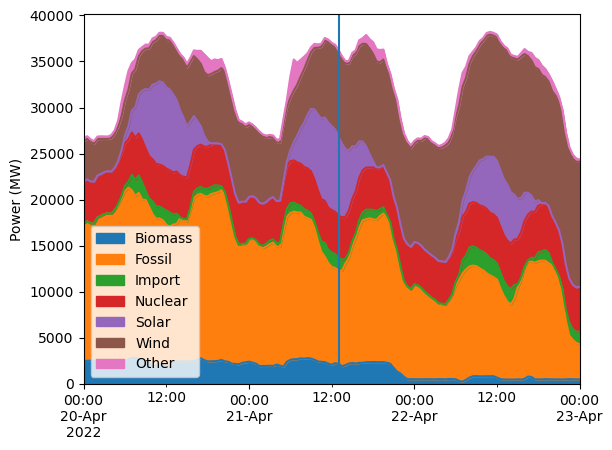

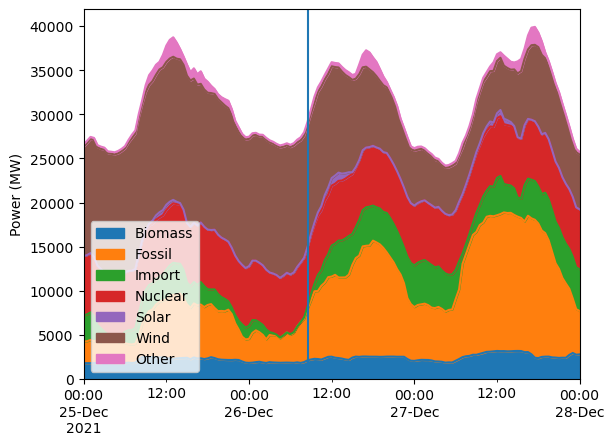

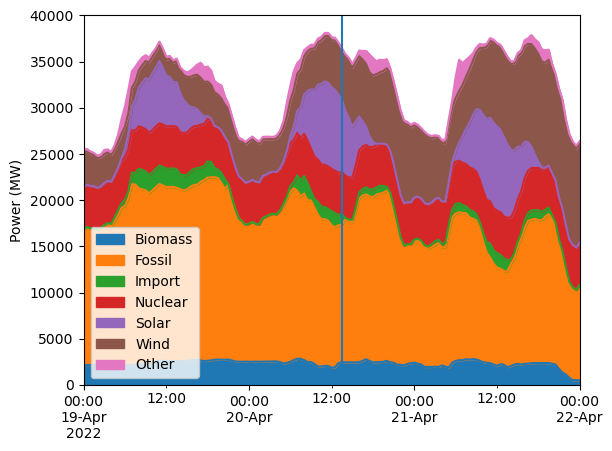

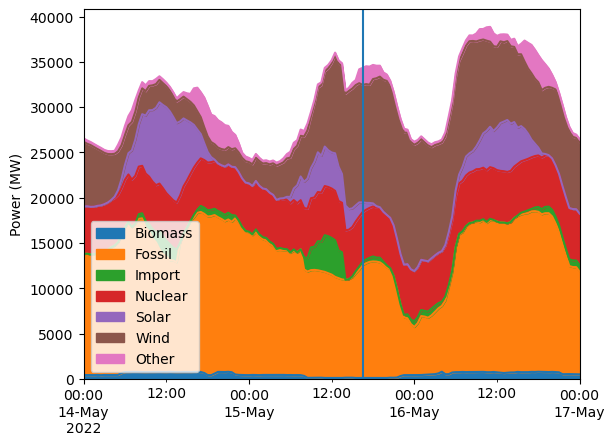

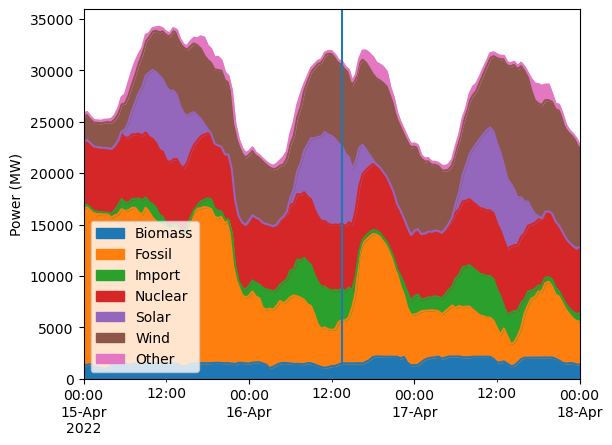

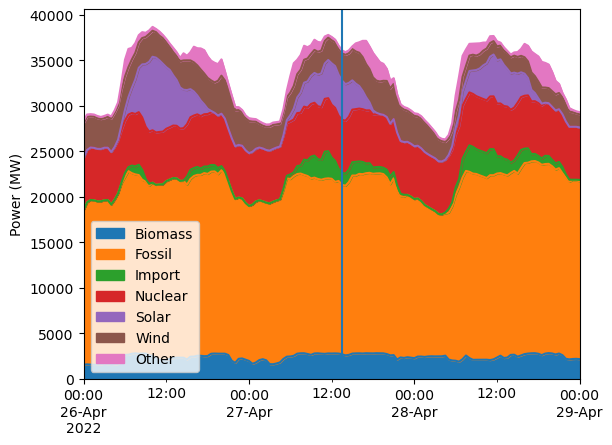

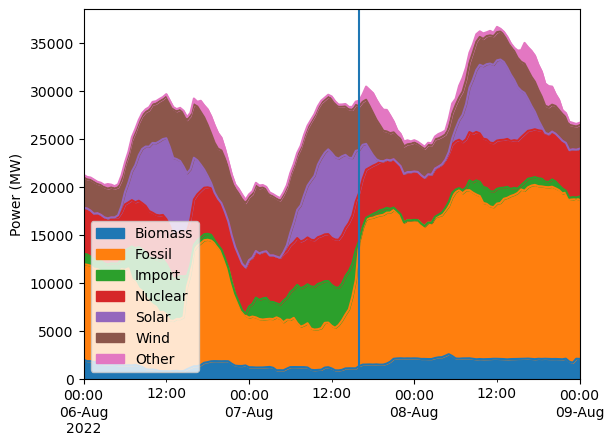

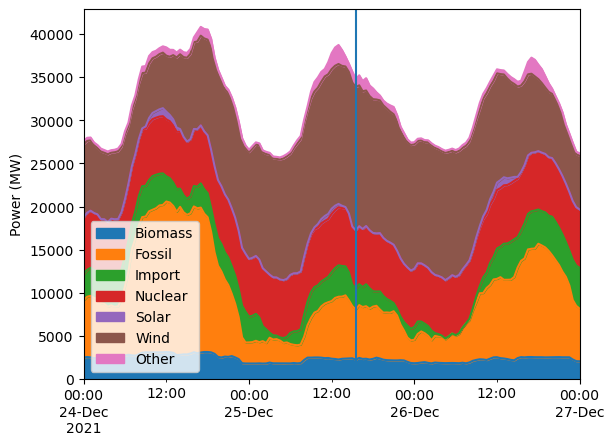

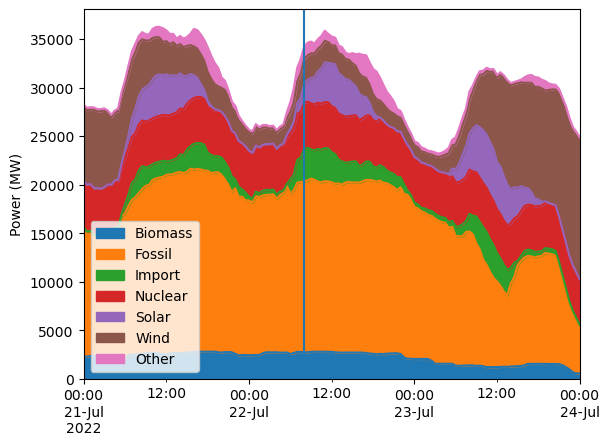

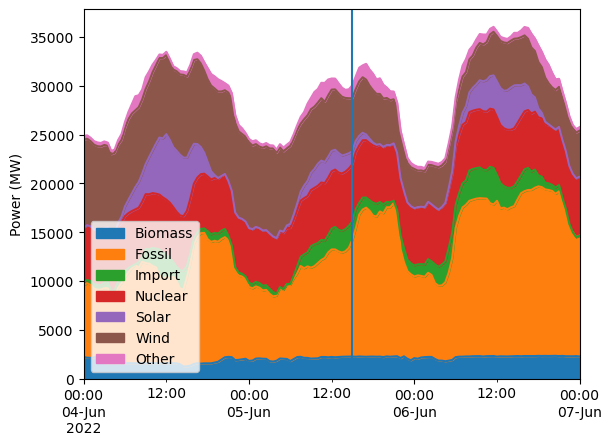

In [5]:
# %%capture --no-display
gen_columns = ["biomass_perc",
    "fossil_perc",
    "imports_perc",
    "nuclear_perc",
    "solar_perc",
    "wind_perc",
    "other_perc"]
gen_labels = ["Biomass",
    "Fossil",
    "Import",
    "Nuclear",
    "Solar",
    "Wind",
    "Other"]



for ii in range(0,5):
    gen_date = event_pos_date[ii].copy()
    gen_date[gen_columns] = gen_date[gen_columns].multiply(gen_date['generation']/100,axis = 'index')    
    gen_date[gen_labels] = gen_date[gen_columns]

    
    gen_date[gen_labels].plot.area()
    plt.legend(loc='lower left')
    plt.axvline(events_pos.index[ii])   
    plt.xlabel('')
    plt.ylabel('Power (MW)')
    
    filename = "Plots\\pos_anom_" + str(ii) +".png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')


    gen_date = event_neg_date[ii].copy()
    gen_date[gen_columns] = gen_date[gen_columns].multiply(gen_date['generation']/100,axis = 'index') 
    gen_date[gen_labels] = gen_date[gen_columns]
        
    ax = gen_date[gen_labels].plot.area()
    ax.legend(loc='lower left')
    ax.axvline(events_neg.index[ii])
    
    plt.xlabel('')
    plt.ylabel('Power (MW)')
    filename = "Plots\\neg_anom_" + str(ii) +".png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    

### Plot Demand by Type on Anomalous Days

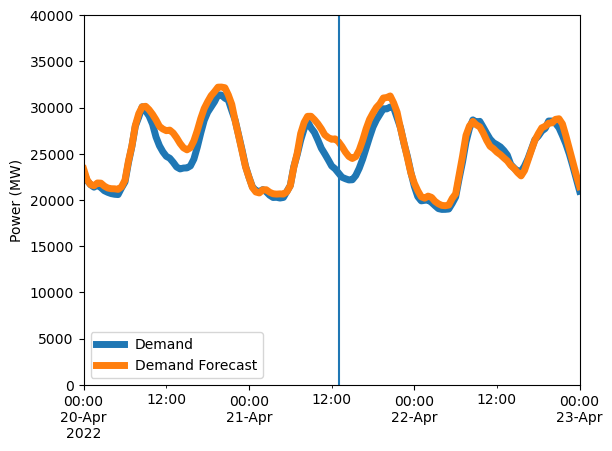

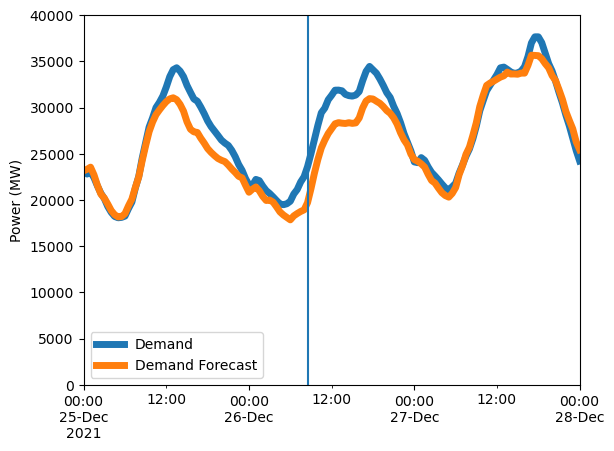

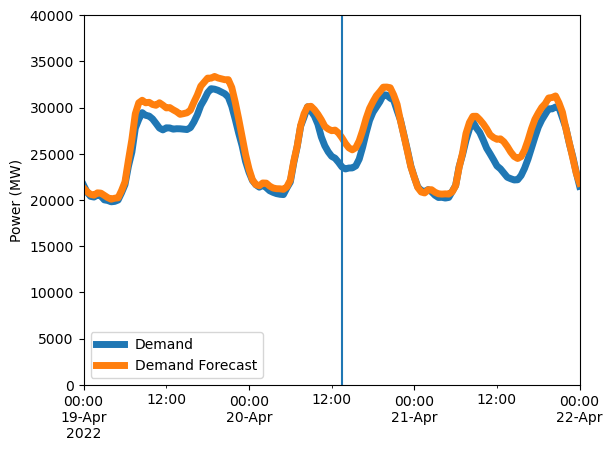

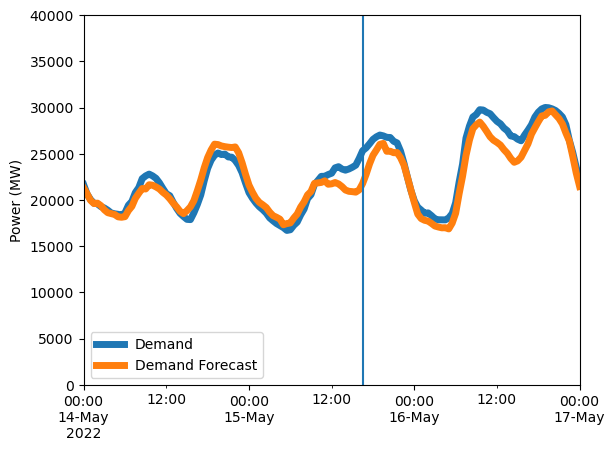

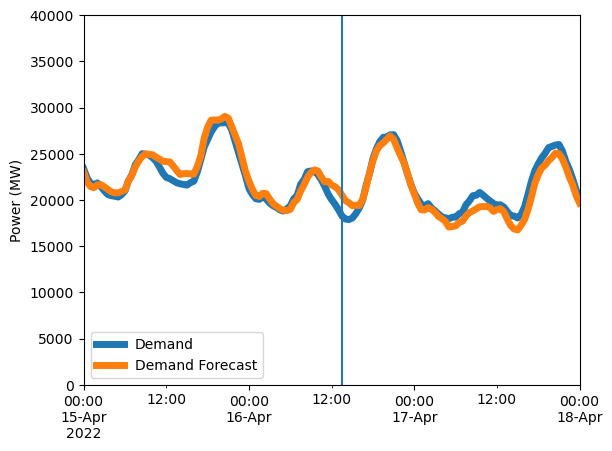

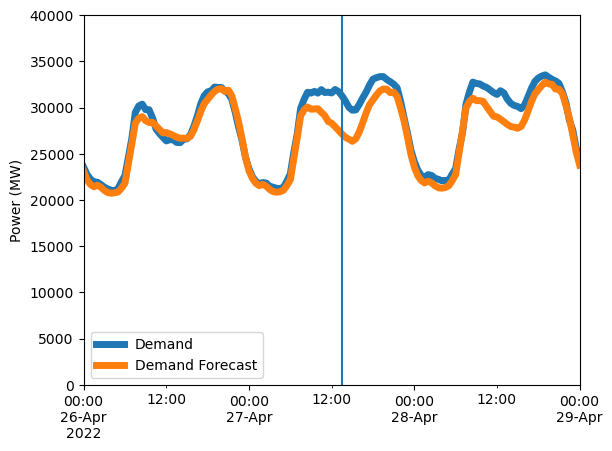

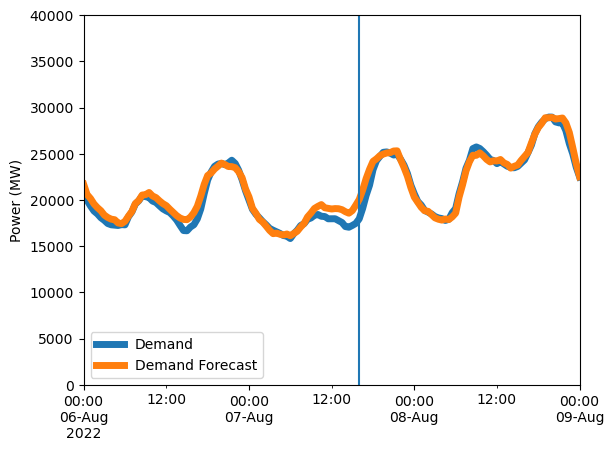

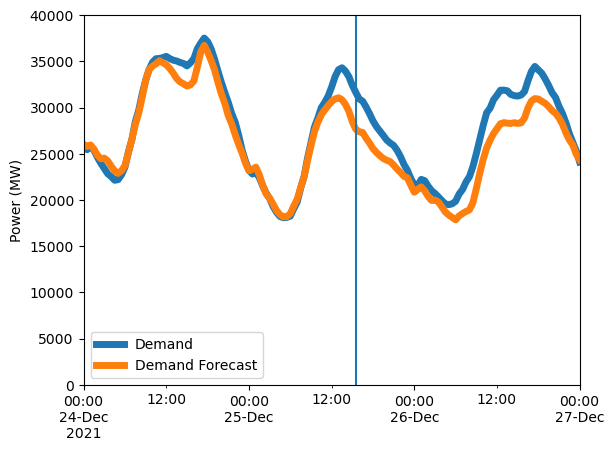

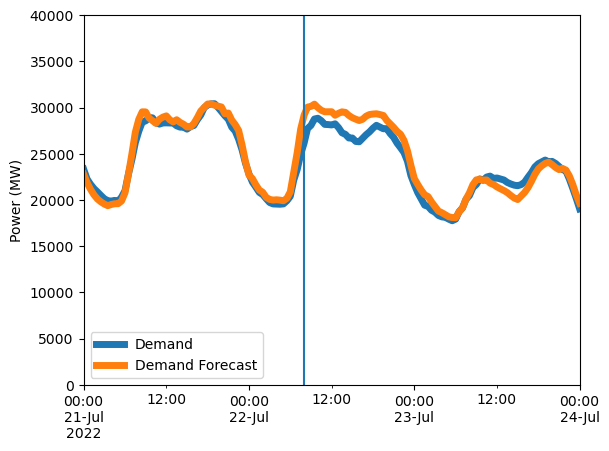

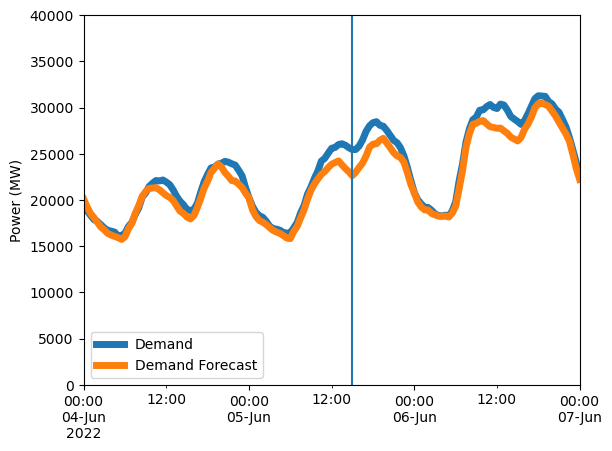

In [6]:
dem_columns = ["demand_outturn","demand_forecast"]
dem_labels = ["Demand","Demand Forecast"]

for ii in range(0,5):
    gen_date = event_pos_date[ii].copy()
    gen_date[gen_columns] = gen_date[gen_columns].multiply(gen_date['generation']/100,axis = 'index')
    
    gen_date[dem_columns].plot(linewidth=5)
    plt.legend(dem_labels,loc='lower left')
    plt.axvline(events_pos.index[ii])
    plt.ylim([0, 40000])
    
    plt.xlabel('')
    plt.ylabel('Power (MW)')
    
    filename = "Plots\\pos_anom_dem" + str(ii) +".png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    
    
    gen_date = event_neg_date[ii].copy()
    gen_date[gen_columns] = gen_date[gen_columns].multiply(gen_date['generation']/100,axis = 'index')
    
    gen_date[dem_columns].plot(linewidth=5)
    plt.legend(dem_labels,loc='lower left')
    plt.axvline(events_neg.index[ii])  
    plt.ylim([0, 40000])
    
    plt.xlabel('')
    plt.ylabel('Power (MW)')
    
    filename = "Plots\\neg_anom_" + str(ii) +".png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')

### Plot Demand on Random Day

2022-08-09


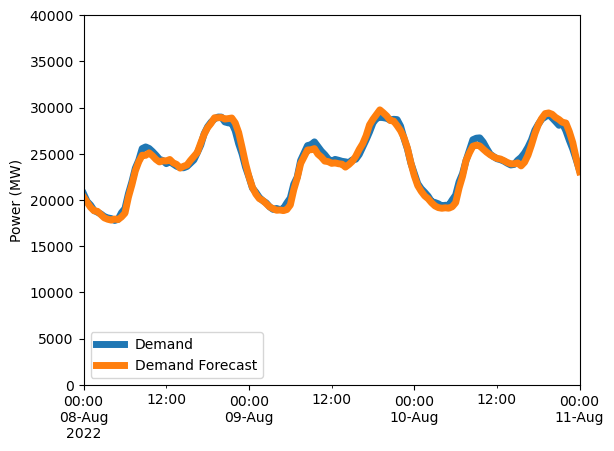

In [7]:
date_sel = pd.to_datetime('2022-08-09',format='%Y-%m-%d').date()
print(date_sel)
event_date = extract_date_range(date_sel,df,n_days)


gen_date = event_date.copy()
gen_date[gen_columns] = gen_date[gen_columns].multiply(gen_date['generation']/100,axis = 'index')
    
gen_date[dem_columns].plot(linewidth=5)
plt.legend(dem_labels,loc='lower left')
plt.axvline(events_pos.index[ii])
plt.ylim([0, 40000])

plt.xlabel('')
plt.ylabel('Power (MW)')
filename = "Plots\\rand_dem" + ".png"
plt.savefig(filename, dpi=300, bbox_inches='tight')

### Plot Demand Error Vs Time

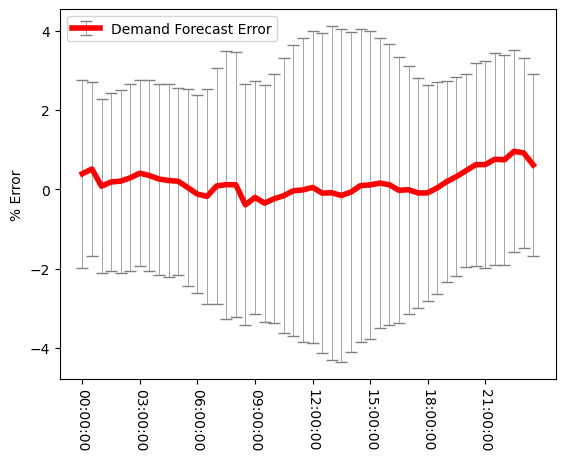

In [8]:
df_grouped = df.groupby([df.index.hour, df.index.minute]).mean()
df_grouped_error = df.groupby([df.index.hour, df.index.minute]).std()


ax = df_grouped['demand_forecast_error'].plot(
    yerr=df_grouped_error['demand_forecast_error'],
    capsize=4,linewidth = 0.5,color = 'gray')

xx = 0
for line in ax.get_lines():
    xx = xx+1
    if xx==1:
        line.set_linewidth(4)
        line.set_color('red')

plt.legend(['Demand Forecast Error'],loc='upper left')
xtick = pd.date_range("00:00", "23:30", freq="30min").time
ax.set_xticks(range(len(xtick)));
ax.locator_params(axis='x', nbins=8)
ax.set_xticklabels(xtick, rotation=-90)
plt.xlabel('')
plt.ylabel('% Error')



filename = "Plots\\Time_Forecast_error" +".png"
plt.savefig(filename, dpi=300, bbox_inches='tight')


### Plot Demand Error Vs Time

C:\Users\kmp57\AppData\Local\Temp\ipykernel_17240\3267033356.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(xtick, rotation=-90)


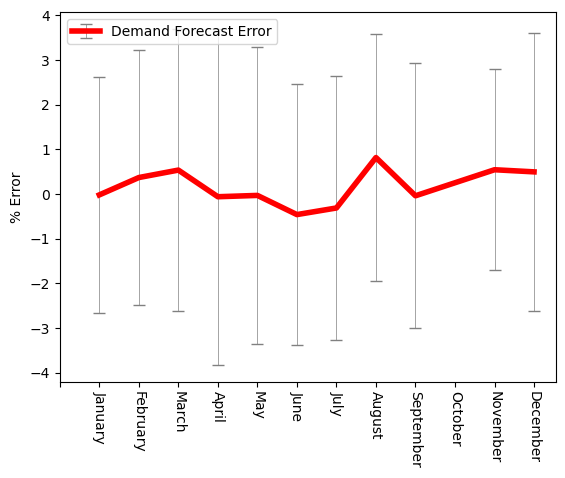

In [9]:
df_grouped = df.groupby([df.index.month]).mean()
df_grouped_error = df.groupby([df.index.month]).std()


ax2 = df_grouped['demand_forecast_error'].plot(
    yerr=df_grouped_error['demand_forecast_error'],
    capsize=4,linewidth = 0.5,color = 'gray')

xx = 0
for line in ax2.get_lines():
    xx = xx+1
    if xx==1:
        line.set_linewidth(4)
        line.set_color('red')
        
        
plt.legend(['Demand Forecast Error'],loc='upper left')
xtick = ['','January', 'February', 'March', 'April',
         'May', 'June', 'July', 'August', 'September',
         'October', 'November', 'December']
ax2.set_xticklabels(xtick, rotation=-90)
ax2.set_xticks(range(len(xtick)));
plt.xlabel('')
plt.ylabel('% Error')


filename = "Plots\\Month_Forecast_error" +".png"
plt.savefig(filename, dpi=300, bbox_inches='tight')